In [88]:
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
import operator

In [89]:
# Set up Grid World
World_Rows = 6
World_Cols = 8
Win_Position = (2, 2)
Start_Position = (5, 0)
Walls = [(1,1),(2,1),(5,1),(1,2),(3,2),(4,2),(1,3),(1,4),(1,5),(2,5),(3,5),(3,6)]

In [90]:
class State:
    def __init__(self, state):
        self.current_state = state
        self.is_win_state = False
        
        
    def is_game_end(self):
        if self.current_state == Win_Position:
            self.is_win_state = True
               
                
    def find_next_state(self, move):
        if move == "up":
            next_state = (self.current_state[0] - 1, self.current_state[1])
        elif move == "down":
            next_state = (self.current_state[0] + 1, self.current_state[1])
        elif move == "right":
            next_state = (self.current_state[0], self.current_state[1] + 1)
        else:
            next_state = (self.current_state[0], self.current_state[1] - 1)
        # If not cliff or wall
        if next_state[0] >= 0 and next_state[0] < World_Rows and \
            next_state[1] >= 0 and next_state[1] < World_Cols and \
                not next_state in Walls:
            return next_state
        
        return self.current_state

    
    def give_reward(self, position):
        # Give reward when win
        if position == Win_Position:
            return 10
        else:
            return -0.2

In [91]:
class Agent:
    def __init__(self, learning_rate = 0.1, discount_factor = 0.9):
        self.State = State(Start_Position)
        self.moves = ['up', 'down', 'right', 'left']
        self.lr = learning_rate
        self.df = discount_factor
        self.step_count = 0
        self.round_reward = 0
        
        # Q(S, A) - each state has 4 values corresponding to possible actions
        self.state_action_values = {} 
        for i in range(World_Rows):
            for j in range(World_Cols):
                self.state_action_values[(i, j)] = {}
                for move in self.moves:
                    self.state_action_values[(i, j)][move] = 0.2
              
            
    def visualise_values(self, final_round = True, round = 0):
        if final_round:
            print("\n")
            print("\n")
            print("Final value table:")
        else:
            if round != 0:
                print("\n")
                print("\n")
            print("Value table for round {}".format(round))
        for i in range(World_Rows):
            print("")
            for j in range(World_Cols):
                if (i, j) == Start_Position:
                    print("S     | ", end = "")
                elif (i, j) == Win_Position:
                    print("E     | ", end = "")
                elif (i, j) in Walls:    
                    print("W     | ", end = "")
                else:
                    action = max(self.state_action_values[(i, j)].items(), key=operator.itemgetter(1))[0]
                    if action == "up":
                        print("{}    | ".format(action), end = "")
                    elif action == "right":
                        print("{} | ".format(action), end = "")
                    else:
                        print("{}  | ".format(action), end = "")
                 
                
    # After each learning round, reset position and number of steps but keep learned values
    def reset(self):
        self.State = State(Start_Position)
        self.step_count = 0
        self.round_reward = 0
        
    
    def choose_move_greedy_epsilon(self, position, ep = 0.15): 
        # Choose random move with probability of epsilon, allowing agent to explore new move
        if np.random.uniform(0,1) <= ep:
            chosen_move = random.choice(self.moves)
            
        # Choose the best option with probability of 1-epsilon
        else:
            chosen_move = self.moves[0]
            temp_next_value = self.state_action_values[position]['up']
            for move in itertools.islice(self.moves, 1, 4):           
                if self.state_action_values[position][move] > temp_next_value:      
                    temp_next_value = self.state_action_values[position][move]
                    chosen_move = move
        
        return chosen_move
    
    
    def move(self, chosen_move):
        self.State.current_state = self.State.find_next_state(chosen_move)
        self.step_count = self.step_count + 1

        
    def learn(self, rounds = 10):
        i = 0
        while i < rounds:
            if self.State.is_win_state:
                steps.append(self.step_count)
                rewards.append(self.round_reward)
                self.reset()
                if i % 200 == 0:
                    self.visualise_values(final_round = False, round = i)
                i = i + 1

            else:
                position = self.State.current_state                                     # S_t
                move = self.choose_move_greedy_epsilon(position)                        # A_t
                
                self.move(move)                                                         # self.State.current_state = S_t+1
                next_move = self.choose_move_greedy_epsilon(self.State.current_state)   # A_t+1
                                                                         
                expected_reward = self.State.give_reward(self.State.current_state)      # R_t+1
                
                #Q(S_t, A_t) = Q(S_t, A_t) + lr * (R_t+1 + df * Q(S_t+1, A_t+1) - Q(S_t, A_t))
                reward = self.state_action_values[position][move] + self.lr * (expected_reward + self.df * self.state_action_values[self.State.current_state][next_move] - self.state_action_values[position][move])
                self.state_action_values[position][move] = reward
                
                self.round_reward = self.round_reward + expected_reward
                
                self.State.is_game_end()
                
                #print("current state is {} and moving {}".format(position, move))
                #print(self.state_action_values[position])
                #print("next state is {}".format(self.State.current_state))
                #print("values of next state: up:{:.3f}, down:{:.3f}, right:{:.3f}, left:{:.3f}".format(self.state_action_values[self.State.current_state[0], self.State.current_state[1], 0],self.state_action_values[self.State.current_state[0], self.State.current_state[1], 1],self.state_action_values[self.State.current_state[0], self.State.current_state[1], 2],self.state_action_values[self.State.current_state[0], self.State.current_state[1], 3]))
                #print("---------------------")
                
        self.visualise_values(final_round = True)

In [94]:
steps = []
rewards = []
ag = Agent(learning_rate = 0.1, discount_factor = 0.99)
ag.learn(rounds = 400)

Value table for round 0

up    | up    | left  | left  | left  | left  | up    | right | 
down  | W     | W     | W     | W     | W     | down  | up    | 
down  | W     | E     | left  | right | W     | left  | up    | 
down  | down  | W     | down  | right | W     | W     | up    | 
right | down  | W     | left  | right | left  | right | down  | 
S     | W     | left  | left  | down  | down  | up    | up    | 



Value table for round 200

right | right | right | right | right | right | down  | down  | 
up    | W     | W     | W     | W     | W     | right | down  | 
up    | W     | E     | left  | left  | W     | right | down  | 
up    | right | W     | up    | left  | W     | W     | down  | 
up    | down  | W     | up    | left  | left  | left  | left  | 
S     | W     | right | up    | up    | up    | left  | up    | 



Final value table:

right | right | right | right | right | right | down  | down  | 
up    | W     | W     | W     | W     | W     | right | down  | 
up    | W   

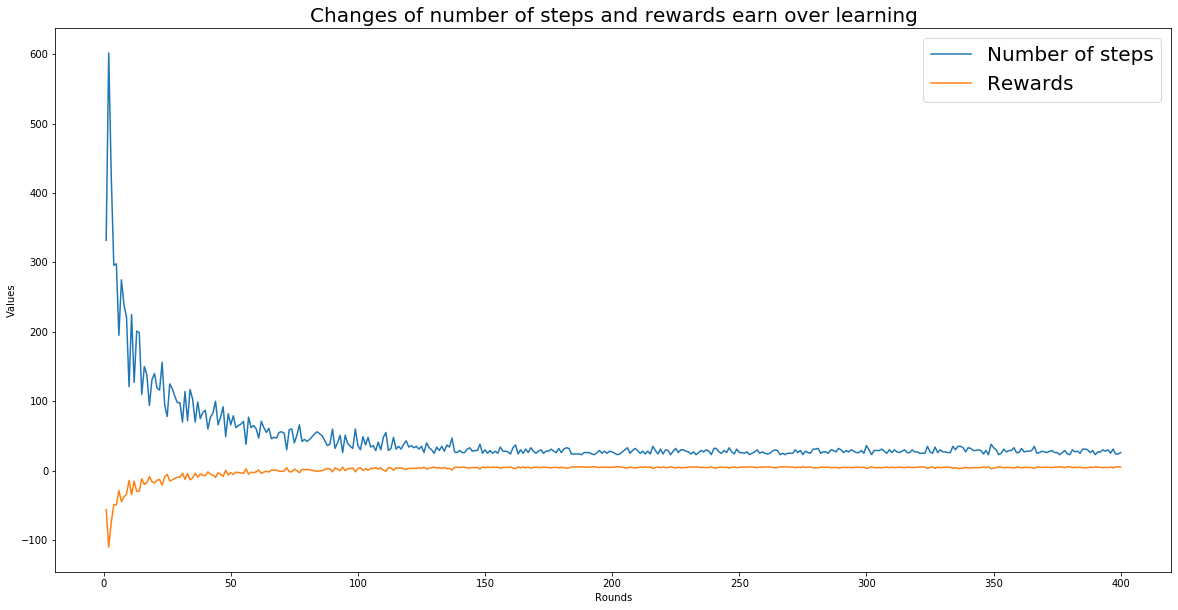

In [95]:
fig, ax = plt.subplots(figsize = (20, 10))
A = np.arange(1, no_rounds + 1)
ax.set_title("Changes of number of steps and rewards earn over learning", fontsize = "20")
ax.set_ylabel("Values")
ax.set_xlabel("Rounds")
ax.plot(A, steps, label = "Number of steps")
ax.plot(A, rewards, label = "Rewards")
ax.legend(loc = "upper right", prop = {"size":20})
fig.savefig("Learning curves.png")